In [1]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import io
import uuid
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from reportlab.lib import colors
from reportlab.lib.units import mm

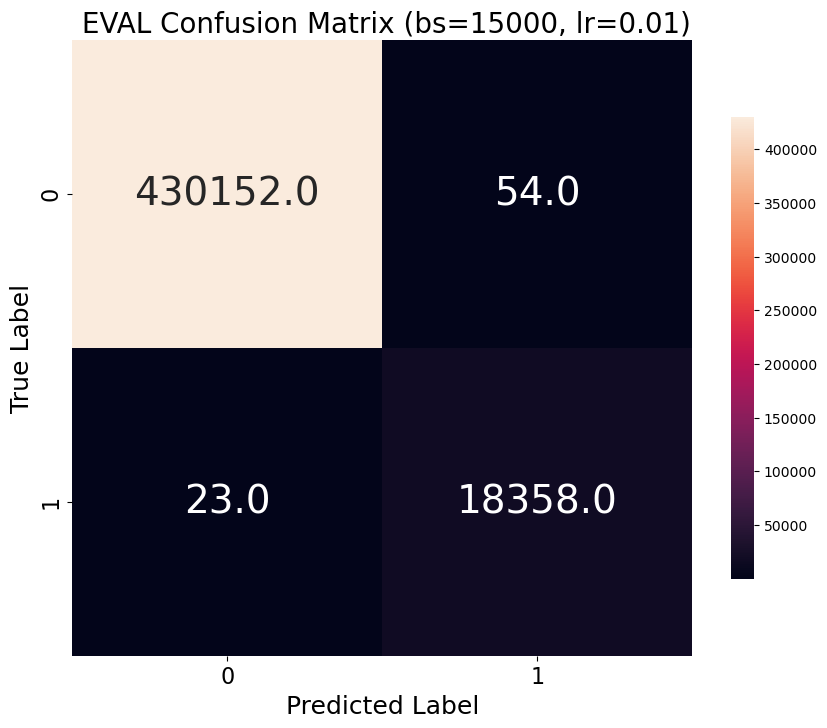

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Matriz de confusión promedio
avg_cm = np.array([[430152, 54],
                   [23, 18358]])

plt.figure(figsize=(10, 8))
sns.heatmap(avg_cm, annot=True, fmt=".1f", annot_kws={"size": 28}, cbar_kws={"shrink": 0.75})
plt.title(" EVAL Confusion Matrix (bs=15000, lr=0.01)", fontsize=20)
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


In [3]:


# ----- FUNCIONES DE ESTILO Y EXPORTACIÓN -----
def wandb_style_table(df, column_colors=None):
    styles = """
    <style>
        .wandb-table {
            border-collapse: collapse;
            width: 100%;
            table-layout: fixed;
            font-family: "Segoe UI", Roboto, Helvetica, Arial, sans-serif;
            font-size: 14px;
            border: 1px solid #e0e0e0;
            border-radius: 6px;
            overflow: hidden;
            box-shadow: 0 2px 6px rgba(0, 0, 0, 0.05);
        }
        .wandb-table th, .wandb-table td {
            padding: 10px 8px;
            border: 1px solid #ddd;
            text-align: center;
            overflow: hidden;
            text-overflow: ellipsis;
            white-space: nowrap;
        }
        .wandb-table th {
            background-color: #f0f7ff;
            color: #333;
            font-weight: 600;
            text-align: center;
        }
    </style>
    """
    if column_colors is None:
        column_colors = {}

    def style_row(row):
        styled_row = ""
        for col, val in row.items():
            bg_color = column_colors.get(col, "")
            style = f"background-color: {bg_color};" if bg_color else ""
            styled_row += f'<td style="{style}">{val}</td>'
        return f"<tr>{styled_row}</tr>"

    header = "".join([f"<th>{col}</th>" for col in df.columns])
    body = "".join([style_row(row) for _, row in df.iterrows()])

    table_html = f"<table class='wandb-table'><thead><tr>{header}</tr></thead><tbody>{body}</tbody></table>"
    return HTML(styles + table_html)


def export_pdf_from_dataframe(df, filename="table.pdf", wide_first_col=False, column_colors=None):
    if column_colors is None:
        column_colors = {}

    formatted_df = df.applymap(lambda x: f"{x:.10f}".rstrip("0").rstrip(".") if isinstance(x, float) else str(x))
    data = [list(formatted_df.columns)] + formatted_df.values.tolist()

    col_width = 30 * mm
    if wide_first_col:
        col_widths = [80 * mm] + [col_width] * (len(df.columns) - 1)
        total_width = 80 * mm + col_width * (len(df.columns) - 1)
    else:
        col_widths = [col_width] * len(df.columns)
        total_width = col_width * len(df.columns)

    row_height = 20
    total_height = row_height * len(data)

    pdf = SimpleDocTemplate(
        filename,
        pagesize=(total_width, total_height),
        leftMargin=0,
        rightMargin=0,
        topMargin=0,
        bottomMargin=0
    )

    table = Table(data, colWidths=col_widths, repeatRows=1)

    styles = [
        ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#f0f7ff')),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.HexColor('#333333')),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 0), (-1, -1), 8),
        ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
        ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.HexColor('#cccccc')),
        ('BOX', (0, 0), (-1, -1), 0.5, colors.HexColor('#cccccc')),
    ]

    for col_idx, col in enumerate(df.columns):
        if col in column_colors:
            color = colors.HexColor(column_colors[col])
            styles.append(('BACKGROUND', (col_idx, 1), (col_idx, -1), color))

    table.setStyle(TableStyle(styles))
    pdf.build([table])
    display(HTML(f'<a href="{filename}" download>Descargar PDF</a>'))


# ----- INTERFAZ Y FUNCIONALIDAD -----
upload = widgets.FileUpload(accept=".csv", multiple=False)
output = widgets.Output()
color_pickers = {}


def on_upload_change(change):
    with output:
        clear_output()

        if not upload.value:
            return

        try:
            uploaded_file = upload.value[0]  # CORREGIDO: ahora accedemos correctamente al archivo
            file_content = uploaded_file['content']
            df = pd.read_csv(io.BytesIO(file_content))

            global color_pickers
            color_pickers = {col: widgets.ColorPicker(description=col, value='#ffffff') for col in df.columns}
            color_picker_ui = widgets.VBox(list(color_pickers.values()))

            columns = widgets.SelectMultiple(
                options=df.columns,
                description="Columnas",
                layout={'width': '400px'}
            )

            filter_col = widgets.Dropdown(
                options=df.columns,
                description="Filtrar por"
            )

            filter_val = widgets.Text(
                description="Valor",
                placeholder="Texto o número"
            )

            sort_col = widgets.Dropdown(
                options=df.columns,
                description="Ordenar por"
            )

            sort_order = widgets.ToggleButtons(
                options=[('Ascendente', True), ('Descendente', False)],
                description='Orden:'
            )

            row_count = widgets.BoundedIntText(
                value=10,
                min=1,
                max=len(df),
                description="Filas"
            )

            update_btn = widgets.Button(description="Actualizar Tabla", button_style='success')
            export_pdf_btn = widgets.Button(description="Exportar PDF", button_style='info')

            wide_first_col = widgets.Checkbox(value=False, description="Primera columna más ancha", indent=False)
            table_output = widgets.Output()

            def get_filtered_df():
                filtered_df = df.copy()
                if filter_col.value and filter_val.value:
                    try:
                        if pd.api.types.is_numeric_dtype(df[filter_col.value]):
                            filtered_df = filtered_df[filtered_df[filter_col.value] == float(filter_val.value)]
                        else:
                            filtered_df = filtered_df[
                                filtered_df[filter_col.value].astype(str).str.contains(filter_val.value, case=False)
                            ]
                    except ValueError:
                        return None

                if columns.value:
                    filtered_df = filtered_df[list(columns.value)]

                if sort_col.value:
                    filtered_df = filtered_df.sort_values(by=sort_col.value, ascending=sort_order.value)

                return filtered_df.head(row_count.value)

            def get_user_column_colors():
                return {col: picker.value for col, picker in color_pickers.items()}

            def update_table(b=None):
                with table_output:
                    table_output.clear_output()
                    result_df = get_filtered_df()
                    if result_df is None:
                        display(HTML("<div style='color:red'>Error: Valor no válido para esta columna</div>"))
                    else:
                        column_colors = get_user_column_colors()
                        display(wandb_style_table(result_df, column_colors=column_colors))

            def on_export_pdf(b):
                result_df = get_filtered_df()
                if result_df is not None:
                    export_pdf_from_dataframe(result_df, wide_first_col=wide_first_col.value, column_colors=get_user_column_colors())

            update_btn.on_click(update_table)
            export_pdf_btn.on_click(on_export_pdf)

            controls = widgets.VBox([
                widgets.Label(value="Selecciona columnas y colores"),
                color_picker_ui,
                widgets.HBox([columns]),
                widgets.HBox([filter_col, filter_val]),
                widgets.HBox([sort_col, sort_order]),
                widgets.HBox([row_count]),
                wide_first_col,
                widgets.HBox([update_btn, export_pdf_btn]),
                table_output
            ])

            display(controls)
            update_table()

        except Exception as e:
            display(HTML(f"<div style='color:red'>Error: {str(e)}</div>"))


upload.observe(on_upload_change, names='value')
display(upload, output)


FileUpload(value=(), accept='.csv', description='Upload')

Output()